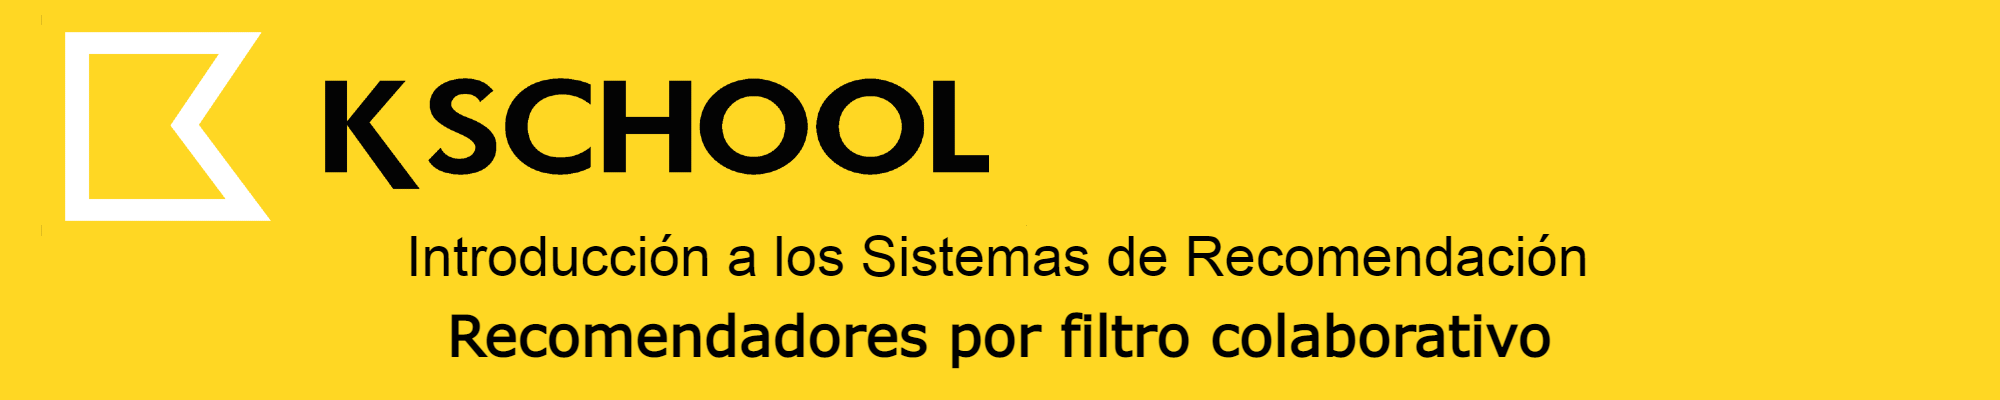

Los recomendadores por filtro colaborativo son de los más usados en la actualidad, y frecuentemente suponen el éxito (o el fracaso) de empresas como Amazon o Netflix.

Se basan en analizar las interacciones entre usuarios e items (ya sea éstos películas, libros, canciones, etc.), y pueden ser clasificados en dos grandes grupos: basados en el usuario o basados en items.

### Filtros basados en el usuario

En este primer caso, el modelo de recomendación parte de la base de que, si dos usuarios tienen un perfil semejante, es probable que lo que le guste a uno también le guste al otro. Es decir, a la hora de realizar una recomendación a un usuario, se buscan usuarios semejantes, se analiza qué les ha gustado y se recomiendan algunos de dichos productos.

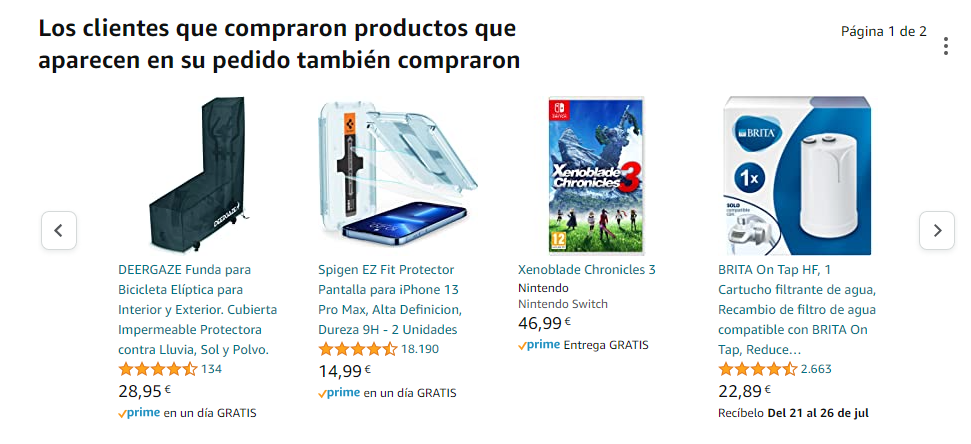

### Filtros basados en items

En este segundo modelo, se parte de la idea de que si dos items suelen tener calificaciones semejantes, entonces ambos deberían satisfacer de forma parecida las necesidades de un cliente. O, dicho de otro modo, si un cliente está interesado en uno de los productos, también podría estar interesado en el segundo.

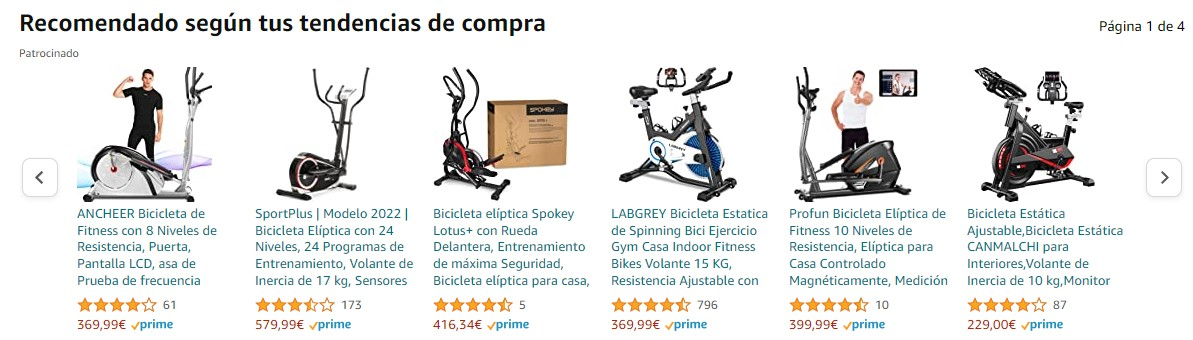

### Problemas de los filtros colaborativos

A pesar de su potencia y eficacia, este tipo de recomendadores tienen ciertas limitaciones que debemos conocer:
* <strong>User cold start</strong>: Si no disponemos de suficiente información sobre un cliente (por ser nuevo, por ejemplo), resulta muy difícil poder encontrar usuarios semejantes y hacerle una recomendación.
* <strong>Item cold start</strong>: Algo semejante ocurre cuando un producto o servicio se añade al portfolio de una empresa, pues mientras no haya un histórico de datos suficiente, resultará difícil poder recomendarlo.
* <strong>Dispersión</strong>: Si tenemos un alto número de clientes y de items, trabajaremos en general con matrices dispersas (en las que la mayor parte de los valores son nulos), y resultará mucho más difícil evaluar el parecido entre usuarios o items.

Para ejecutar un recomendador de este tipo, comenzamos cargando algunas librerías:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os

In [2]:
names = lambda obj: print([name for name in dir(obj) if name[0] != "_"])

# Lectura de los datos

También ahora trabajaremos con el <strong>Full MovieLens Dataset</strong>, aun cuando los ficheros a usar no serán los mismos que hemos usado en el apartado dedicado a los rankings. Una vez más, deberemos apuntar a la carpeta en la que estén los datos:

In [3]:
path = "./data/ml-100k/"

### Datos de usuarios

Carguemos ahora los datos de los usuarios:

In [4]:
column_names = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv(os.path.join(path, "u.user"), sep = "|", names = column_names)

In [5]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
users.shape

(943, 5)

### Datos de películas

Ahora, carguemos la información sobre las películas:

In [7]:
column_names = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown',
'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
'Western']
movies = pd.read_csv(os.path.join(path, "u.item"), sep = "|", names = column_names,
    encoding = "latin-1")

In [8]:
movies.head()

,movie_id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


De esta tabla nos interesa solo el identificador y el título:

In [9]:
movies = movies.filter(["movie_id", "title"])
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [10]:
movies.shape

(1682, 2)

### Datos de valoraciones

Por último, carguemos los datos de las valoraciones que las películas han recibido de los usuarios:

In [11]:
column_names = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv("./data/ml-100k/u.data", sep = "\t", names = column_names)

In [12]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
ratings.shape

(100000, 4)

Vemos que la tabla incluye una votación por registro, indicándose el identificador del usuario, el identificador de la película siendo votada, la valoración recibida (campo <strong>rating</strong>) y un <i>timestamp</i> indicando cuándo se produjo la votación.

Las valoraciones son números enteros entre 1 y 5:

In [14]:
ratings.rating.unique()

array([3, 1, 2, 4, 5], dtype=int64)

Podemos visualizar la distribución de las notas para entender un poco mejor los datos con los que estamos trabajando:

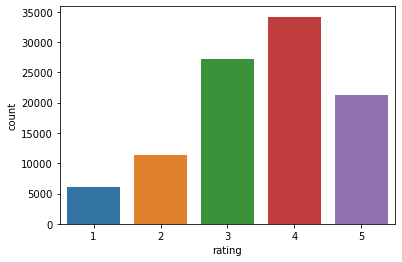

In [15]:
sns.countplot(x = ratings.rating)
plt.show()

Comprobamos que la mayor parte de las notas se encuentran en el rango 3-5.

# Obtención de los datasets de entrenamiento y validación

El objetivo es ser capaces de predecir la puntuación que un usuario va a dar a un item pues, una vez hemos predicho este valor para todos los items, bastaría con recomendarle aquellos items con mejores predicciones.

Con este objetivo, vamos a aplicar a la tabla de ratings el llamado "<i>método de retención</i>" o "<i>holdout</i>", dividiéndola en dos bloques: uno para entrenar nuestro modelo, y otro para validarlo.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train, test = train_test_split(ratings, stratify = ratings.user_id, random_state = 18)

Por defecto, el 25% de los datos han ido al dataset de validación, y nos aseguramos de que la distribución de los usuarios sea semejante en los dos datasets resultantes.

# Evaluación

Necesitamos ahora establecer la métrica con la que vamos a medir el error de la predicción. Una buena métrica es la raíz cuadrada del valor medio de la suma de los cuadrados de los errores individuales (es decir, la raíz cuadrada del error cuadrático medio). Scikit-Learn nos ofrece una función para calcular este último:

In [18]:
from sklearn.metrics import mean_squared_error

Pero, si queremos obtener la raíz cuadrada de dicho valor, tendremos que crear nosotros esta función, a la que podemos llamar <strong>rmse</strong>:

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Probémosla suponiendo que en <i>y_true</i> tenemos los valores reales y en <i>y_pred</i> nuestra predicción:

In [20]:
y_true = [2, 1, 5, 4, 4]
y_pred = [2, 2, 5, 5, 3]
rmse(y_true, y_pred)

0.7745966692414834

Este valor es el mismo que obtenemos si realizamos el cálculo manualmente:

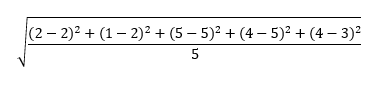

In [21]:
np.sqrt(((2 - 2) ** 2 + (1 - 2) ** 2 + (5 - 5) ** 2 + (4 - 5) ** 2 + (4 - 3) ** 2) / 5)

0.7745966692414834

Por supuesto, si los vectores son iguales, la raíz del error cuadrático medio es cero:

In [22]:
y_true = [2, 1, 5, 4, 4]
y_pred = [2, 1, 5, 4, 4]
rmse(y_true, y_pred)

0.0

### Baseline

Definamos un "modelo" que nos sirva de referencia. Este modelo -el más simple que podemos imaginar- va a predecir que el rating que cualquier usuario va a dar a una película va a ser 3:

In [23]:
def baseline(user, movie):
    return 3

Y definamos también una función que pruebe nuestro modelo en todos los registros del dataset de evaluación y nos devuelva el error cometido:

In [24]:
def score(modelo, test):
    data = zip(test.user_id, test.movie_id)  # Llevamos a tuplas las parejas de usuario y película
    y_pred = np.array([modelo(user, movie) for (user, movie) in data]) # Generamos las predicciones
    y_true = test.rating                     # Valores reales
    return rmse(y_true, y_pred)              # Calculamos el error

Como nuestro modelo "<i>baseline</i>" recibe un usuario y una película, en nuestra función <i>score</i> convertimos los usuarios y películas del dataset de evaluación en un iterable formado por tuplas (que contienen las parejas de usuarios y películas), para poder pasar ambos valores al modelo usando una "<i>comprehension list</i>" y generar, de este modo, la predicción para todo el dataset.

In [25]:
score(baseline, test)

1.238159925050072

Este primer "score" es el que deberemos mejorar...

# Recomendación basada en usuario

Implementemos un sistema de recomendación por filtro colaborativo. Antes de nada seleccionamos un usuario aleatorio para ver más adelante qué recomendaciones le va a hacer nuestro modelo:

In [26]:
random_user = int(users["user_id"].sample(random_state = 1))
random_user

786

### Matriz de calificaciones

Aunque tenemos un DataFrame conteniendo las valoraciones de los usuarios a las películas, necesitamos convertirlo en una tabla en la que se crucen ambas dimensiones (usuarios y películas), con la valoración en la intersección. Podemos conseguir esto usando el método <strong>.pivot_table()</strong> de Pandas:

In [27]:
ratings_matrix = train.pivot_table(index = "user_id", columns = "movie_id", values = "rating")
ratings_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,NaN,NaN,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,NaN,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como vemos, se trata de una matriz en la que la mayor parte de los valores son nulos.

### 1 - Recomendación del valor medio

Una primera opción para predecir la puntuación que un usuario dará a una película es devolver el valor medio que haya recibido la película. En este caso, esta puntuación sería la misma para cualquier usuario, pero cada película tendría una valoración distinta a las demás. Se trata de un caso particular de filtro por ranking en el que utilizamos como métrica el valor medio de las valoraciones sin modificar el resultado:

In [28]:
def mean_recommender(user, movie):
    if movie in ratings_matrix:
        return ratings_matrix[movie].mean()
    else:
        return 3

In [29]:
score(mean_recommender, test)

1.0265549986996743

Comprobamos que, a pesar de la sencillez del método, mejoramos el resultado que obtuvimos con el modelo base.

###### Recomendación

¿Cuál sería la recomendación a nuestro usuario aleatorio? Veamos, en primer lugar, las predicciones que nuestro modelo devolvería para las películas que tenemos en nuestro dataset:

In [30]:
recommendations = []
for movie in movies.movie_id:
    recommendations.append(mean_recommender(random_user, movie))

Es decir, creamos una lista vacía y recorremos las películas añadiendo a la lista el valor devuelto por nuestro modelo.

In [31]:
recommendations

[3.8641618497109826,
 3.161290322580645,
 3.014925373134328,
 3.5759493670886076,
 3.3442622950819674,
 3.5454545454545454,
 3.8187919463087248,
 4.089820359281437,
 3.868995633187773,
 3.8285714285714287,
 3.8323353293413174,
 4.388349514563107,
 3.4057971014492754,
 4.020833333333333,
 3.755656108597285,
 3.269230769230769,
 3.0597014925373136,
 2.6666666666666665,
 4.0,
 3.4727272727272727,
 2.7611940298507465,
 4.171806167400881,
 4.088888888888889,
 3.4307692307692306,
 3.482142857142857,
 3.3653846153846154,
 3.125,
 3.9330143540669855,
 2.6341463414634148,
 4.071428571428571,
 3.586206896551724,
 3.7704918032786887,
 3.4583333333333335,
 2.75,
 2.25,
 2.0,
 2.25,
 2.9204545454545454,
 3.328125,
 2.7954545454545454,
 3.2857142857142856,
 3.8086956521739133,
 3.0833333333333335,
 3.380952380952381,
 4.068965517241379,
 3.4761904761904763,
 3.669811320754717,
 4.096385542168675,
 3.2241379310344827,
 4.404157043879907,
 3.5166666666666666,
 3.7580645161290325,
 2.932584269662921,
 

Si ordenamos la lista de mayor a menor, obtendríamos los mayores valores predichos:

In [32]:
pd.Series(recommendations).sort_values(ascending = False)

1466    5.0
1292    5.0
1174    5.0
1598    5.0
1593    5.0
       ... 
1585    1.0
1582    1.0
1581    1.0
1578    1.0
1342    1.0
Length: 1682, dtype: float64

Para generalizar el resultado y poder devolver no solo las predicciones, sino también los nombres de las películas, definamos una función que reciba el modelo siendo usado, un usuario, el número de resultados a obtener, y devuelva las películas ordenadas según el valor predicho, de mayor a menor:

In [33]:
def recommendations(modelo, user, n = 10):
    recommended_movies = movies.copy()   # Hacemos una copia independiente del dataset
    # Creamos una nueva columna con el valor predicho para cada película
    recommended_movies["prediction"] = [modelo(user, movie) for movie in movies.movie_id]
    # Devolvemos la tabla ordenada
    return recommended_movies.sort_values("prediction", ascending = False)[:n]

Veamos la recomendación a nuestro usuario aleatorio:

In [34]:
recommendations(mean_recommender, random_user)

,movie_id,title,prediction
1466,1467,"Saint of Fort Washington, The (1993)",5.0
1292,1293,Star Kid (1997),5.0
1174,1175,Hugo Pool (1997),5.0
1598,1599,Someone Else's America (1995),5.0
1593,1594,Everest (1998),5.0
1188,1189,Prefontaine (1997),5.0
1200,1201,Marlene Dietrich: Shadow and Light (1996),5.0
1535,1536,Aiqing wansui (1994),5.0
1499,1500,Santa with Muscles (1996),5.0
1652,1653,Entertaining Angels: The Dorothy Day Story (1996),5.0


Podemos comparar este resultado con el que obtenemos al pasar a nuestro recomendador el modelo "<i>baseline</i>":

In [35]:
recommendations(baseline, random_user)

,movie_id,title,prediction
0,1,Toy Story (1995),3
1104,1105,Firestorm (1998),3
1128,1129,Chungking Express (1994),3
1127,1128,Heidi Fleiss: Hollywood Madam (1995),3
1126,1127,"Truman Show, The (1998)",3
1125,1126,"Old Man and the Sea, The (1958)",3
1124,1125,"Innocents, The (1961)",3
1123,1124,"Farewell to Arms, A (1932)",3
1122,1123,"Last Time I Saw Paris, The (1954)",3
1121,1122,They Made Me a Criminal (1939),3


En este último caso el orden de las películas es totalmente arbitrario pues la predicción es la misma para todas ellas.